In [1]:
import torch
from dataset import load_dataset
from basic_unet import UNet
import matplotlib.pyplot as plt
import sys
sys.path.append('visual_attribution')  # noqa: E402
from explainer.gradcam import GradCAMExplainer
from torch.autograd import Variable
import numpy as np
from torch.nn.functional import interpolate

In [2]:
class SinglePixelModel():
    def __init__(self, real_model, x, y):
        self.real_model = real_model
        self.x = x
        self.y = y
        self._modules = self.real_model._modules

    def __call__(self, *args, **kwargs):
        output = self.real_model(*args, **kwargs)
        x = output[0][self.x][self.y]
        x = x.unsqueeze(0).unsqueeze(0)
        return x

In [3]:
def upsample(inp, size):
    scale = size / inp.shape[3]
    return interpolate(inp, scale_factor=scale, mode='bilinear', align_corners=False)


def explain(model, output, x, y, target_layer_keys):
    fake_model = SinglePixelModel(model, x, y)
    tensor = Variable(image, requires_grad=True)
    explainer = GradCAMExplainer(fake_model, target_layer_name_keys=target_layer_keys)
    target = torch.LongTensor([0]).to(device)
    saliency1 = explainer.explain(tensor, target)
    saliency2 = upsample(saliency1, 240)
    attr = np.abs(saliency2.cpu().numpy()).max(axis=1).squeeze()
    attr -= attr.min()
    attr /= (attr.max() + 1e-20)
    return attr

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size=1)
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

# fetch a random sample from the dataset
sample = next(iter(test_loader))
image = sample['input'].to(device)
output = model(image)
output = output.detach().cpu().squeeze().numpy()
# binarize output
output = (output > output.mean())

In [5]:
def find_first_pixel(output):
    for x in range(output.shape[0]):
        for y in range(output.shape[1]):
            if output[x][y]:
                return x, y


x, y = find_first_pixel(output)

# generate a image with the analyzed pixel and his 8 adjacent pixels set to red
# the rest of the image is completely transparent so it can be showed on top of the saliency output
marker = np.zeros(output.shape)
marker[x-1][y-1] = 1.0
marker[x-1][y] = 1.0
marker[x-1][y+1] = 1.0
marker[x][y-1] = 1.0
marker[x][y] = 1.0
marker[x][y+1] = 1.0
marker[x+1][y-1] = 1.0
marker[x+1][y] = 1.0
marker[x+1][y+1] = 1.0

blank = np.zeros(output.shape)
pixel_mask = np.dstack([marker, blank, blank, marker])

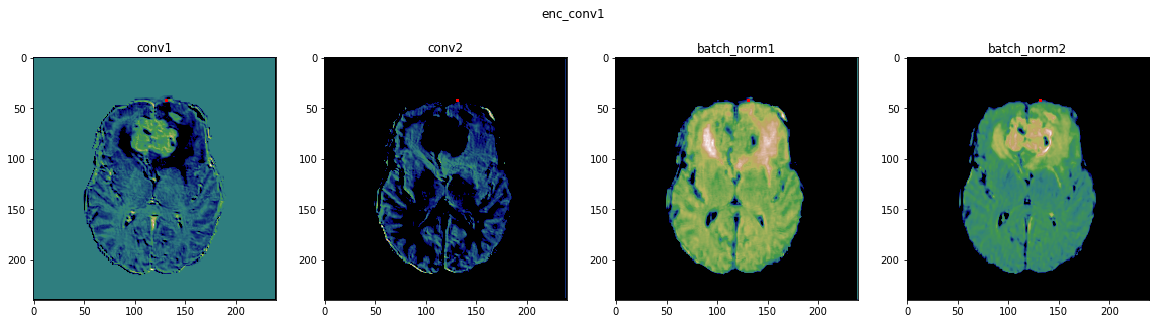

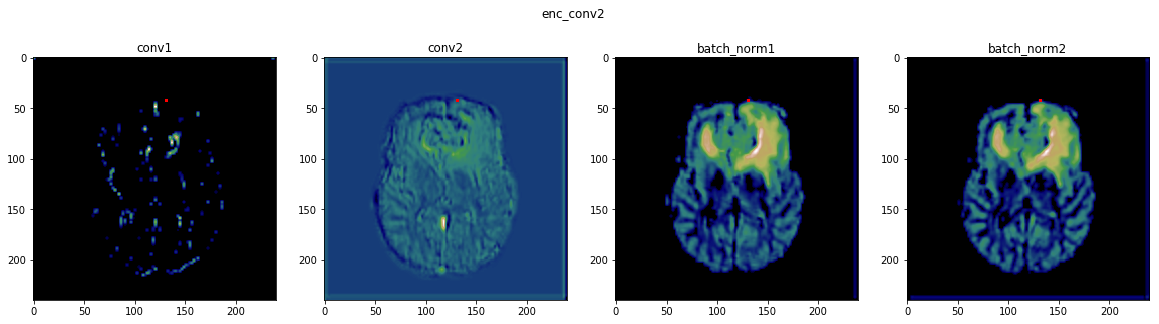

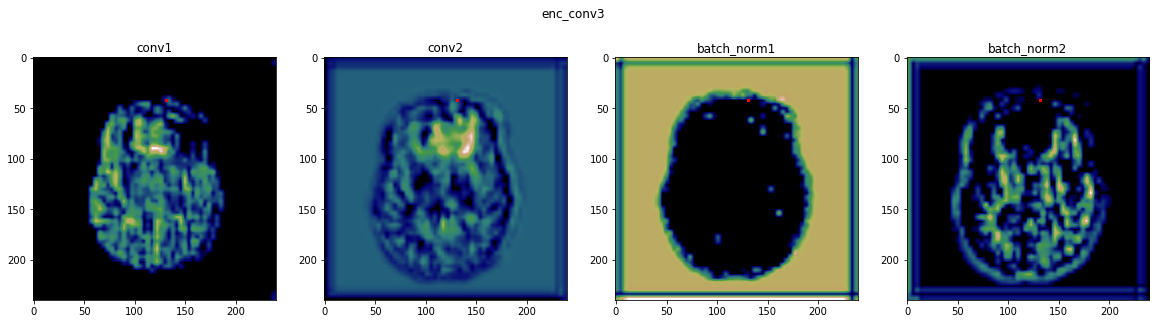

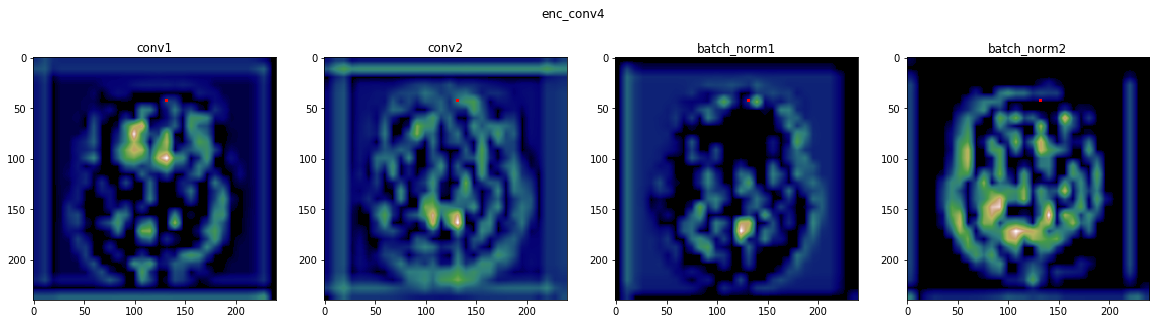

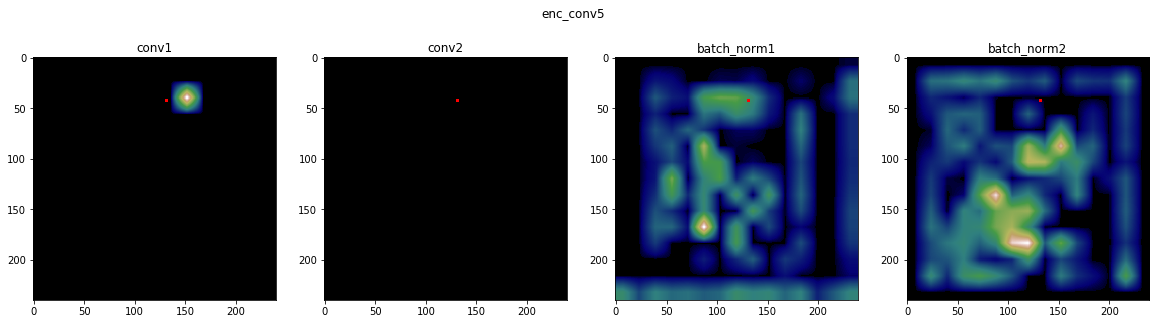

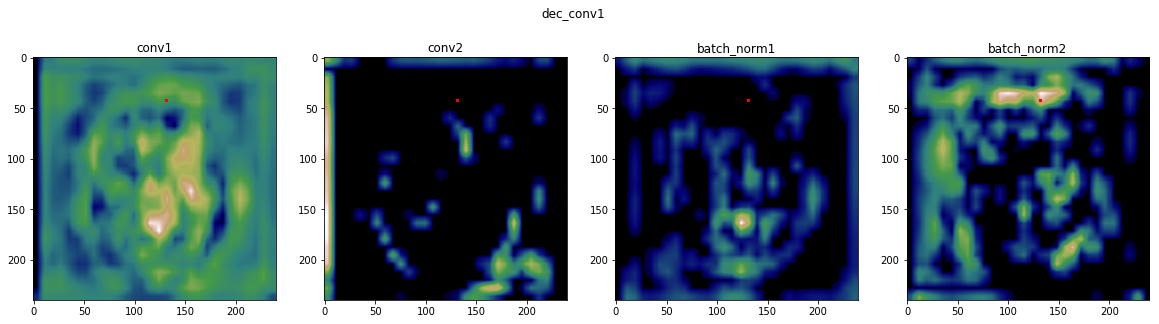

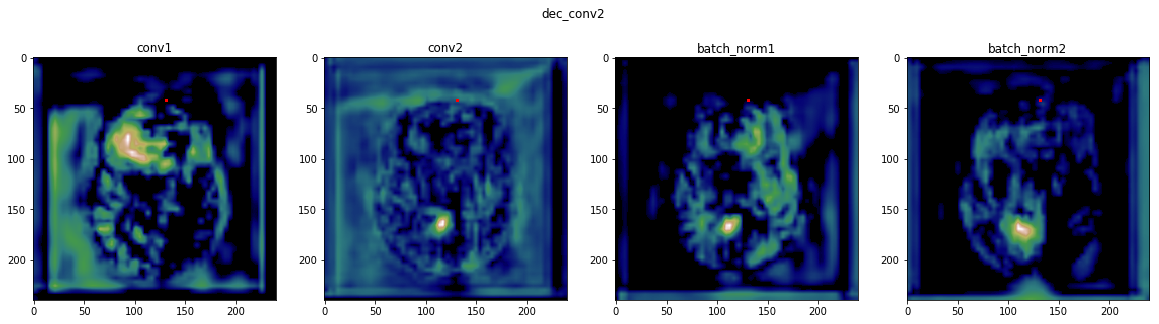

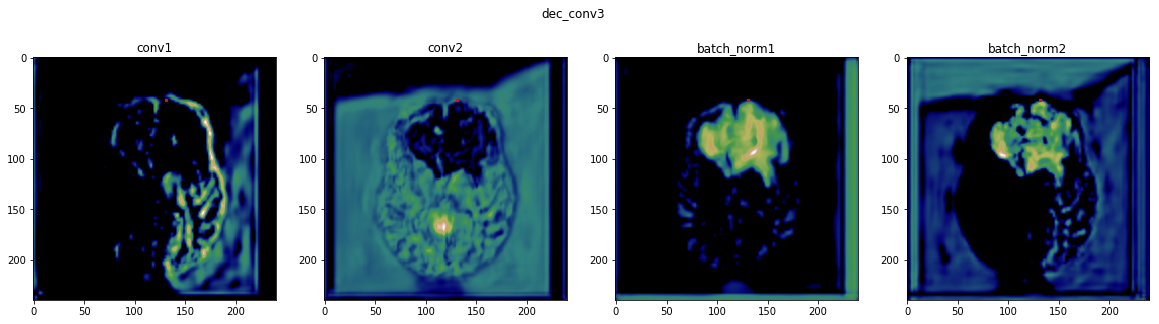

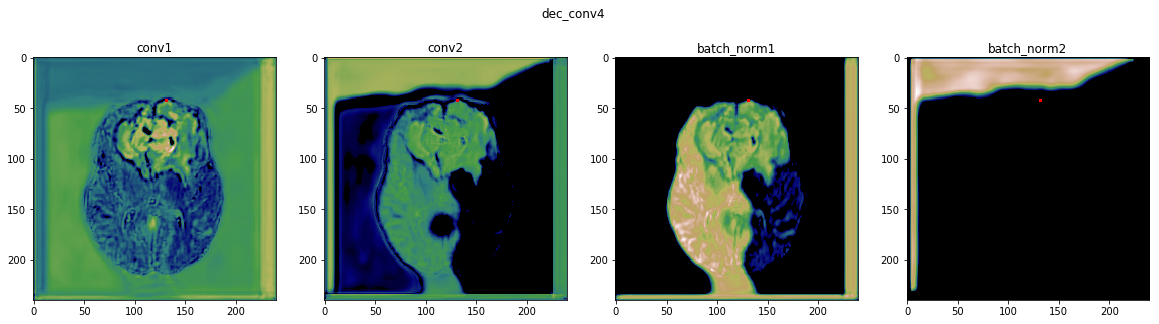

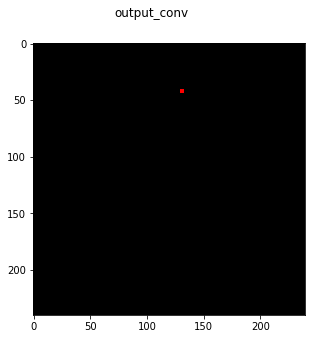

In [6]:
for module_name, module in model.named_children():
    # reload model from disk to avoid out of memory errors
    saliency_model = UNet(in_channels=4, out_channels=1)
    saliency_model.load_state_dict(state_dict)
    saliency_model = saliency_model.to(device)

    saliencies = []
    labels = []

    children = list(module.named_children())

    # iterate of module content (module is a ConvRelu2 in basic_unet.py)
    if len(children) > 0:
        for layer_name, layer in children:
            saliency = explain(saliency_model, output, x, y, [module_name, layer_name])
            saliencies.append(saliency)
            labels.append(layer_name)
    else:  # output conv layer is not a module, just a Conv2d layer and has therefore no children
        saliency = explain(saliency_model, output, x, y, [module_name])
        saliencies.append(saliency)

    # display saliencies of the current module
    figure, plots = plt.subplots(1, len(saliencies), figsize=(20, 5))

    # special case for output conv layer
    if not isinstance(plots, np.ndarray):
        plots = [plots]

    figure.suptitle(module_name)
    for i, saliency in enumerate(saliencies):
        plot = plots[i]
        plot.imshow(saliency, cmap='gist_earth')
        plot.imshow(pixel_mask)
        if labels:
            plot.set_title(labels[i])

    plt.show()